## GR5241 Statistical Machine Learning
### Data Analysis Project Milestone 2
### Name: Kangshuo Li  UNI: kl3259
![](GR5241_PROJ2_Q3.png)
![](GR5241_PROJ2_Q4.png)

### Setup

In [25]:
import torch
import torchvision
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import Variable
import pandas as pd
import numpy as np
import sklearn
import matplotlib
from matplotlib import pyplot as plt
import time
import random
import os
import re
import pickle
%xmode plain
print(os.getcwd()) # on colab pro

Exception reporting mode: Plain
/content


In [26]:
# check GPU
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.cuda.is_available()

True

### Read in data

In [27]:
# Data download and preprocessing
from torch.utils import data

DOWNLOAD_MNIST = True # If already download , set as False

train_data = torchvision.datasets.MNIST(
    root ="./mnist/",
    train = True , # this is training data
    # transform = torchvision.transforms.ToTensor(),
    download = DOWNLOAD_MNIST
)
test_data = torchvision.datasets.MNIST(root = "./mnist/", train = False)

### Preprocessing

In [28]:
# preprocessing: normalized
X_train = torch.from_numpy(train_data.train_data.numpy() / 255).to(device)
X_test = torch.from_numpy(test_data.test_data.numpy() / 255).to(device)
Y_train = train_data.train_labels.to(device)
Y_test = test_data.test_labels.to(device)
train_data = TensorDataset(X_train, Y_train)
test_data = TensorDataset(X_test, Y_test)

# Y_train_onehot = F.one_hot(Y_train).to(device)
# Y_test_onehot = F.one_hot(Y_test).to(device)
# train_data_onehot = TensorDataset(X_train, Y_train_onehot)
# test_data_onehot = TensorDataset(X_test, Y_test_onehot)

/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:65: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:70: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


### Instantiate dataloader

In [29]:
# instantiate dataloader
train_dataloader = DataLoader(train_data, batch_size = 64, shuffle = True)
test_dataloader = DataLoader(test_data, batch_size = 64, shuffle = True)

### 3.

In [30]:
# define the structure single layer neural network
class single_layer_NN(nn.Module):
    def __init__(self):
        super(single_layer_NN, self).__init__()
        self.flatten = nn.Flatten()
        self.single_layer_nn = nn.Sequential(
            nn.Linear(784, 100),
            nn.Sigmoid(),
            nn.Linear(100, 10),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.flatten(x)
        prob_softmax = self.single_layer_nn(x)
        return prob_softmax

# instantiate nn and move to GPU 
model_single_layer = single_layer_NN().to(device)
# print model structure
print(model_single_layer)

single_layer_NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (single_layer_nn): Sequential(
    (0): Linear(in_features=784, out_features=100, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=100, out_features=10, bias=True)
    (3): Sigmoid()
  )
)


In [31]:
# def the path for saving models
from google.colab import drive
drive.mount('/content/drive')
%mkdir '/content/drive/My Drive/GR5241/'
PATH = '/content/drive/My Drive/GR5241/'
os.getcwd()

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/content/drive/My Drive/GR5241/’: File exists


'/content'

In [35]:
def train_loop(dataloader_, model_, loss_fn_, optimizer_, epoch_, seed_):
    size = len(dataloader_.dataset)
    num_batches = len(dataloader_)
    sum_cross_entropy_error = 0
    correct_case = 0
    for step, (batch_x, batch_y) in enumerate(dataloader_):
        # Compute prediction and loss
        prediction = model_(batch_x.float())
        loss = loss_fn_(prediction, batch_y)
        sum_cross_entropy_error += loss_fn_(prediction, batch_y).item()
        correct_case += (prediction.argmax(1) == batch_y).type(torch.float).sum().item()

        # Backpropagation
        optimizer_.zero_grad()
        loss.backward()
        optimizer.step()

    # print when finished
    avg_cross_entropy_error = sum_cross_entropy_error / size
    avg_mis_clf_error = 1 - correct_case / size
    print(f"Current seed: {seed_:6d}|Train Loss - cross entropy: {avg_cross_entropy_error:10.6f}|Train Loss - mis-clf: {avg_mis_clf_error:10.6f}")
    return avg_cross_entropy_error, avg_mis_clf_error

def test_loop(dataloader_, model_, loss_fn_, seed_):
    size = len(dataloader_.dataset)
    num_batches = len(dataloader_)
    sum_cross_entropy_error, correct_case = 0, 0

    with torch.no_grad():
        for step, (batch_x, batch_y) in enumerate(dataloader_):
            prediction = model_(batch_x.float())
            sum_cross_entropy_error += loss_fn_(prediction, batch_y).item()
            # test_loss += loss_fn_(prediction, batch_y).item()
            correct_case += (prediction.argmax(1) == batch_y).type(torch.float).sum().item()

    # test_loss /= num_batches
    correct_case /= size
    avg_mis_clf_error = 1 - correct_case
    avg_cross_entropy_error = sum_cross_entropy_error / size
    print(f"Test Accuracy: {(100 * correct_case):4.1f}%|Test Loss - cross entropy: {avg_cross_entropy_error:11.6f}|Test Loss - mis-clf: {avg_mis_clf_error:11.6f} \n")
    return avg_cross_entropy_error, avg_mis_clf_error

# try at least 5 times with different random seed
start_time = time.time()
random_seed_list = [42, 422, 4422, 44222, 4442222, 44442222]
learning_rate = 0.1
batch_size = 100
epochs = 180
for seed in random_seed_list:
    # create the dataframe for storing the two types of loss used in 3(a) and 3(b)
    globals()['loss_df_' + str(seed)] = pd.DataFrame(
        data = np.zeros((epochs, 4)), 
        columns = ["Cross_entropy_error_train", "Misclassification_error_train", "Cross_entropy_error_test", "Misclassification_error_test"], 
        index = np.arange(1, epochs + 1, dtype = int)
    )
    # random.seed(seed)
    torch.manual_seed(seed)
    # create new single layer NN
    # re-instantiate NN and move to GPU 
    model_single_layer = single_layer_NN().to(device)
    # create optimizer
    optimizer = optim.SGD(
        model_single_layer.parameters(), 
        lr = learning_rate
    )
    # create cost function
    loss_fn = nn.CrossEntropyLoss(reduction = 'sum') # multiclass classification
    # specifiying reduction with 'sum' and compute the mean with number of examples inside the train test loops
    # default is 'mean' for weighted mean
    print(f"Seed {seed}\n================================================================================================")
    for t in np.arange(epochs):
        print(f"Epoch {t + 1}\n------------------------------------------------------------------------------------------------")
        avg_corss_entropy_error_train, avg_mis_clf_error_train = train_loop(
            dataloader_ = train_dataloader, 
            model_ = model_single_layer, 
            loss_fn_ = loss_fn, 
            optimizer_ = optimizer, 
            epoch_ = epochs,
            seed_ = seed
        )
        avg_corss_entropy_error_test, avg_mis_clf_error_test = test_loop(
            dataloader_ = test_dataloader, 
            model_ = model_single_layer, 
            loss_fn_ = loss_fn, 
            seed_ = seed
        )
        # add two types of errors to their corresponding df
        globals()['loss_df_' + str(seed)].loc[(t + 1), "Cross_entropy_error_train"] = avg_corss_entropy_error_train
        globals()['loss_df_' + str(seed)].loc[(t + 1), "Misclassification_error_train"] = avg_mis_clf_error_train
        globals()['loss_df_' + str(seed)].loc[(t + 1), "Cross_entropy_error_test"] = avg_corss_entropy_error_test
        globals()['loss_df_' + str(seed)].loc[(t + 1), "Misclassification_error_test"] = avg_mis_clf_error_test
    # save model
    torch.save(model_single_layer, PATH + "model_single_layer_seed_" + str(seed) + ".pkl")

print(f"================================================================================================")
time_cost = time.time() - start_time
print(f'Finished! Time cost: {time_cost:0.4f}s') # on colab pro


Streaming output truncated to the last 5000 lines.
Current seed:     42|Train Loss - cross entropy:   1.466683|Train Loss - mis-clf:   0.007450
Test Accuracy: 97.7%|Test Loss - cross entropy:    1.489071|Test Loss - mis-clf:    0.023300 

Epoch 84
------------------------------------------------------------------------------------------------
Current seed:     42|Train Loss - cross entropy:   1.466662|Train Loss - mis-clf:   0.007450
Test Accuracy: 97.7%|Test Loss - cross entropy:    1.489614|Test Loss - mis-clf:    0.023300 

Epoch 85
------------------------------------------------------------------------------------------------
Current seed:     42|Train Loss - cross entropy:   1.466641|Train Loss - mis-clf:   0.007383
Test Accuracy: 97.7%|Test Loss - cross entropy:    1.489306|Test Loss - mis-clf:    0.023500 

Epoch 86
------------------------------------------------------------------------------------------------
Current seed:     42|Train Loss - cross entropy:   1.466605|Train L

In [36]:
# save the loss_dfs
for seed in random_seed_list:
    with open(PATH + "loss_df_seed_" + str(seed) + ".pkl", 'wb') as file:
        pickle.dump(globals()['loss_df_' + str(seed)], file)

#### (a)

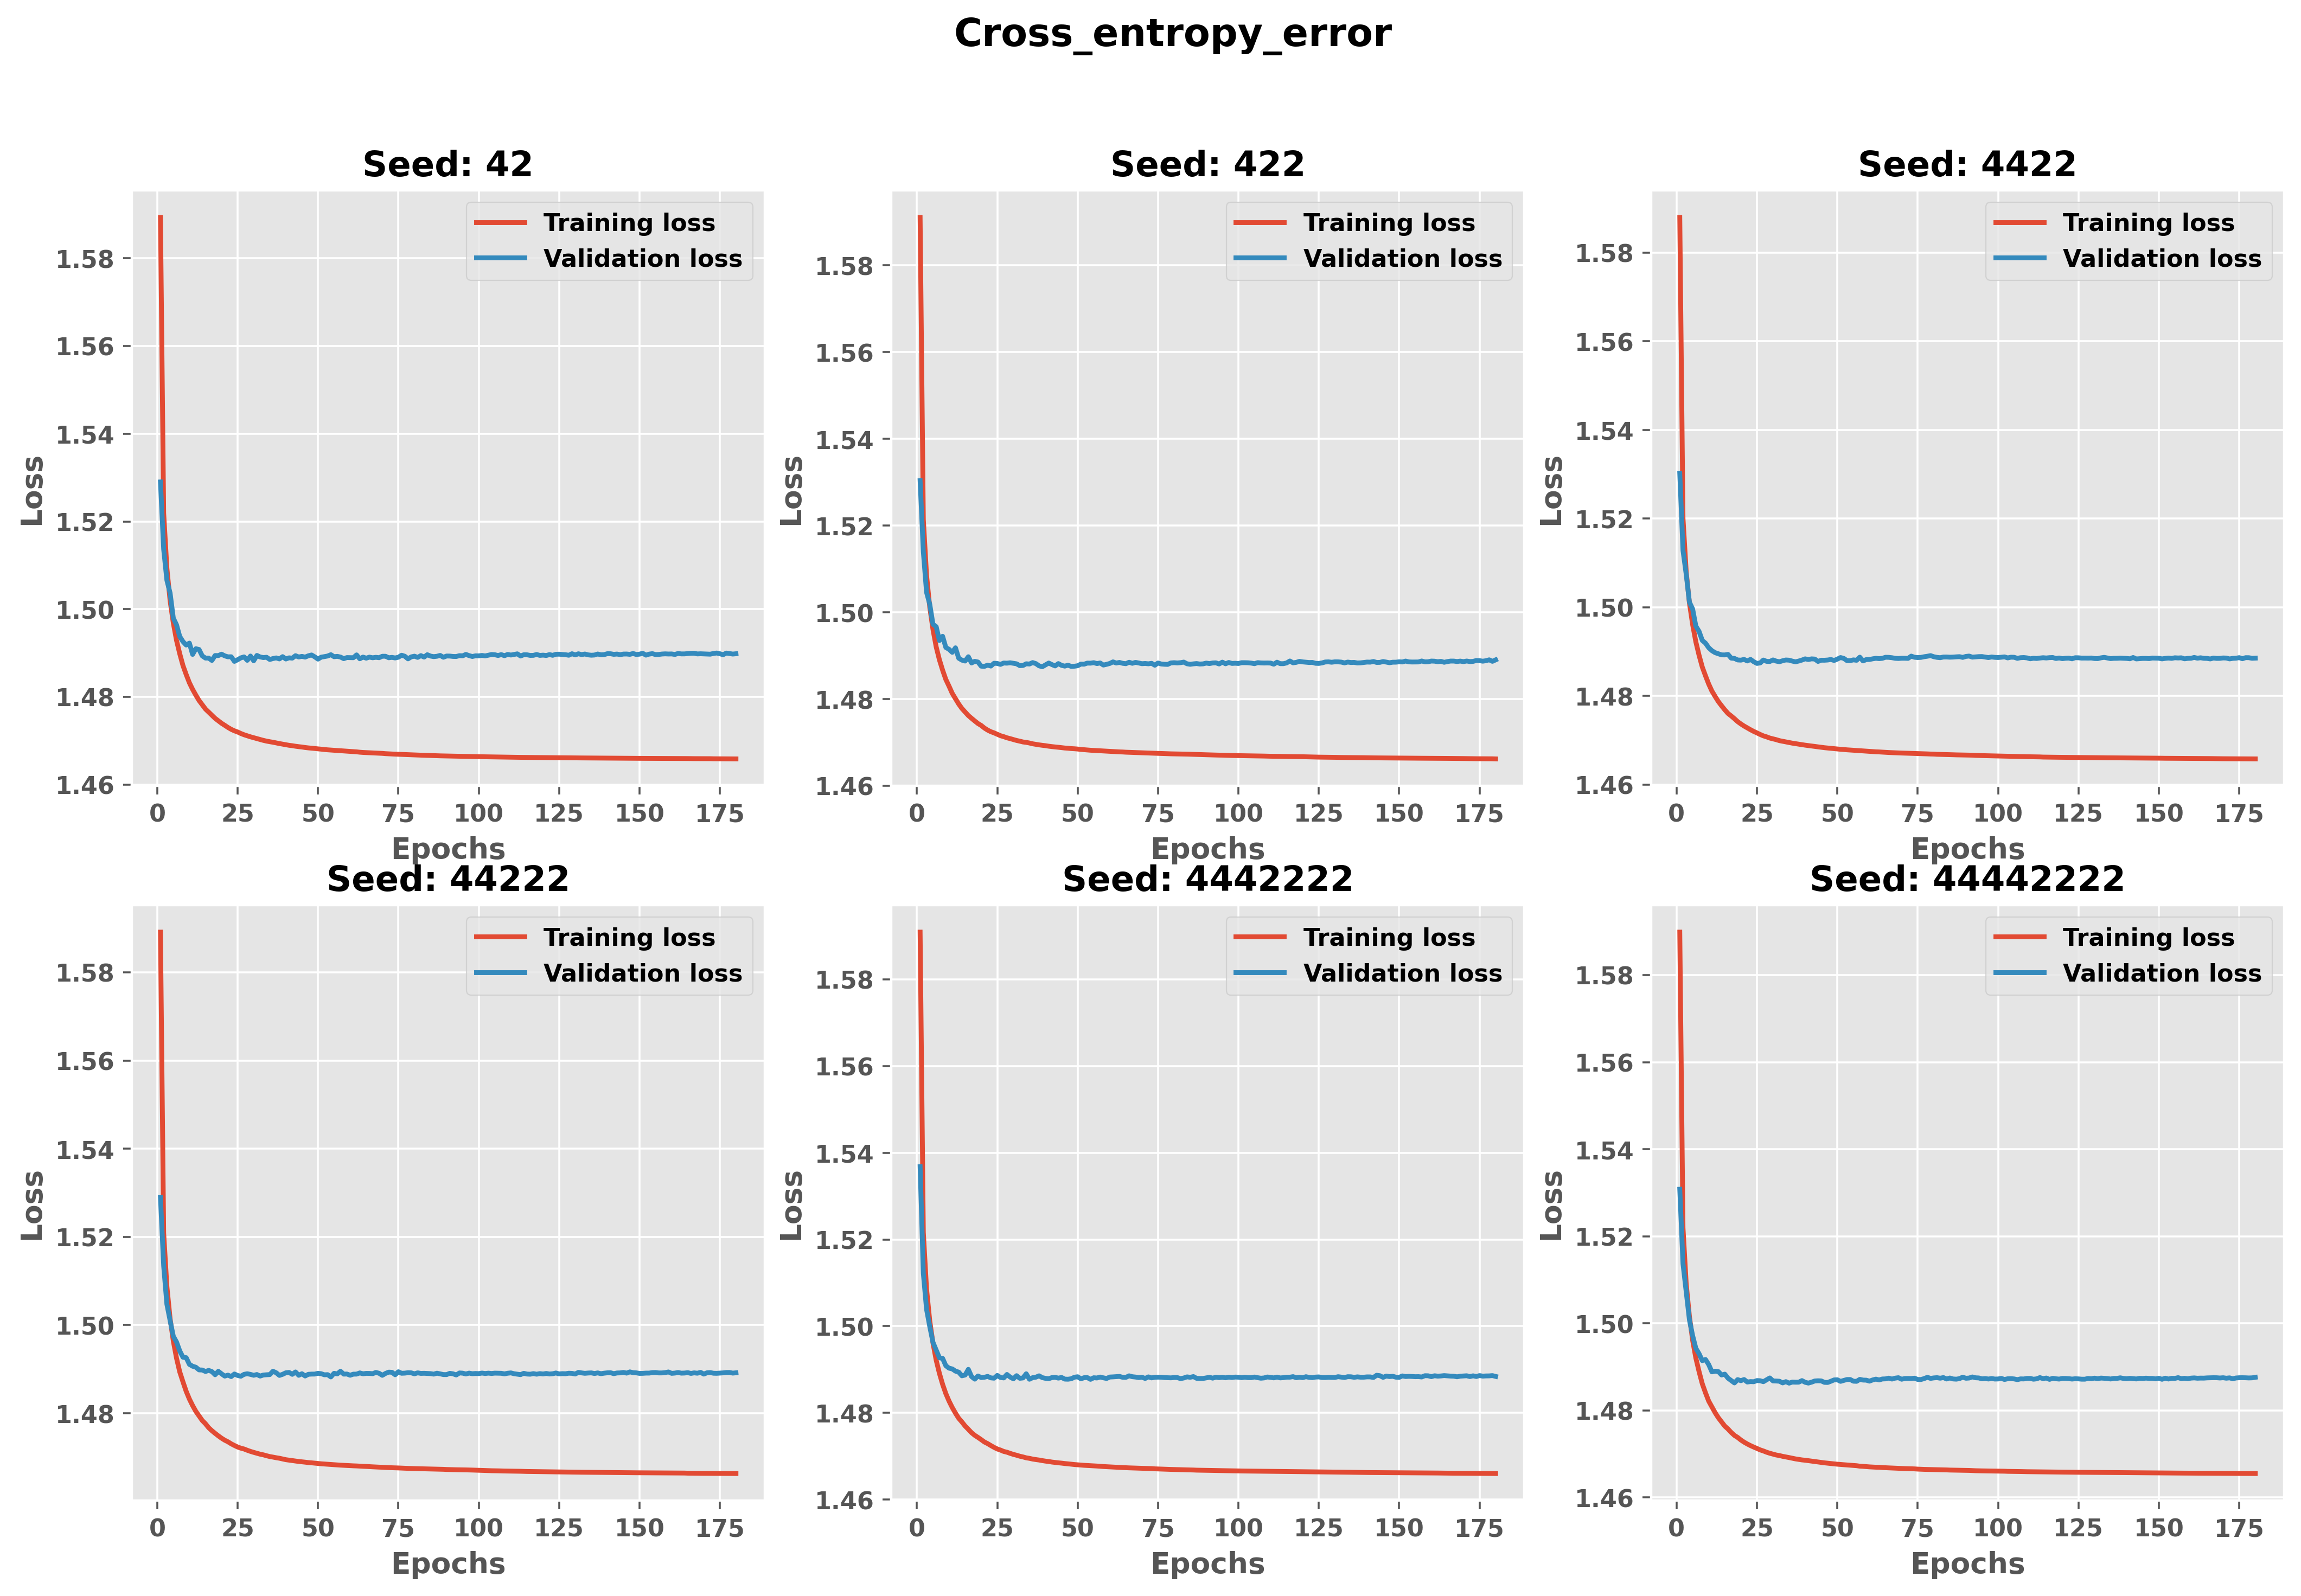

In [57]:
from torch.utils.data.dataset import random_split
# Plot the average training cross-entropy error vs. the epochs
# define function for plotting in 3(a) and 3(b)
def plot_error(fig_title, loss_df = None, random_seed_list = None, error_type = "Cross_entropy", lay_out = "single"):
    '''
    Input: loss_df for the loss function value at each epoch of both type and 
           both training and testing set
           lay_out: control the output fig whether for "multi_seeds" or "single"
    Output: fig file in png + show the fig inline
    '''
    # style setup
    plt.style.use('ggplot')
    plt.rcParams["font.weight"] = "bold"
    plt.rcParams["axes.labelweight"] = "bold"
    plt.rcParams["axes.titleweight"] = "bold"
    if lay_out == "single":
        # use loss_df local variable
        assert loss_df != None
        fig, ax = plt.subplots(1, 1, figsize = (6, 6), dpi = 320)
        epoch_list = np.arange(1, loss_df.shape[0] + 1, dtype = int)
        train_loss_list = loss_df.loc[:, error_type + "_error_train"]
        test_loss_list = loss_df.loc[:, error_type + "_error_test"]
        ax.plot(epoch_list, train_loss_list, '-', label = "Training loss", linewidth = 2)
        ax.plot(epoch_list, test_loss_list, '-', label = "Validation loss", linewidth = 2)
        ax.legend()
        ax.set_title('Learning Curve: ' + fig_title)
        ax.set_xlabel('Epochs')
        ax.set_ylabel('Loss')
        fig.savefig(
            PATH + "learning_curve_" + fig_title + ".png", 
            format = "png"
        )
        plt.show()
    elif lay_out == "multi_seeds":
        # use random seed and global dfs to get loss_df data
        assert random_seed_list != None
        fig, ax = plt.subplots(2, 3, figsize = (16, 10), dpi = 320)
        count = 0
        for i in np.arange(2): # row
            for j in np.arange(3): # col
                curr_ax = ax[i, j]
                curr_loss_df = globals()['loss_df_' + str(random_seed_list[count])]
                curr_epoch_list = np.arange(1, curr_loss_df.shape[0] + 1, dtype = int)
                curr_train_loss_list = curr_loss_df.loc[:, error_type + "_error_train"]
                curr_test_loss_list = curr_loss_df.loc[:, error_type + "_error_test"]
                curr_ax.plot(curr_epoch_list, curr_train_loss_list, '-', label = "Training loss", linewidth = 2)
                curr_ax.plot(curr_epoch_list, curr_test_loss_list, '-', label = "Validation loss", linewidth = 2)
                curr_ax.legend()
                curr_ax.set_title('Seed: ' + str(random_seed_list[count]))
                curr_ax.set_xlabel('Epochs')
                curr_ax.set_ylabel('Loss')
                count += 1 # udpate random seed and corresponding loss_df
        fig.suptitle(fig_title, fontsize = 16, weight = "bold")
        fig.savefig(
            PATH + "learning_curve_" + fig_title + ".png", 
            format = "png"
        )
        plt.show()
    pass

# Ex: plot cross-entropy error curve for NN with a single seed
# plot_error(
#     loss_df = loss_df_42, 
#     fig_title = "Cross_entropy_error_seed_42", 
#     error_type = "Cross_entropy", 
#     lay_out = "single"
# )

# plot the cross-entropy error curve for all seeds
plot_error(
    random_seed_list = random_seed_list, 
    fig_title = "Cross_entropy_error", 
    error_type = "Cross_entropy", 
    lay_out = "multi_seeds"
)